<a href="https://colab.research.google.com/github/jmq19950824/Graph-Neural-Networks/blob/main/GNN_SAGEConv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

From "Hands-on Graph Neural Networks with PyTorch & PyTorch Geometric"——https://towardsdatascience.com/hands-on-graph-neural-networks-with-pytorch-pytorch-geometric-359487e221a8


The SAGEConv is from the paper "Inductive Representation Learning on Large Graphs", NIPS 2017

In [1]:
#import some necessary packages
try:
  import torch
  import torch_geometric
except:
  !pip install -q torch-scatter -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
  !pip install -q torch-sparse -f https://data.pyg.org/whl/torch-1.10.0+cu113.html
  !pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  import torch
  import torch_geometric

     |████████████████████████████████| 7.9 MB 5.6 MB/s 
     |████████████████████████████████| 3.5 MB 4.8 MB/s 
     |████████████████████████████████| 145 kB 5.4 MB/s 
     |████████████████████████████████| 112 kB 45.4 MB/s 
     |████████████████████████████████| 74 kB 3.0 MB/s 
     |████████████████████████████████| 596 kB 36.8 MB/s 


### A toy examples for understanding the graph

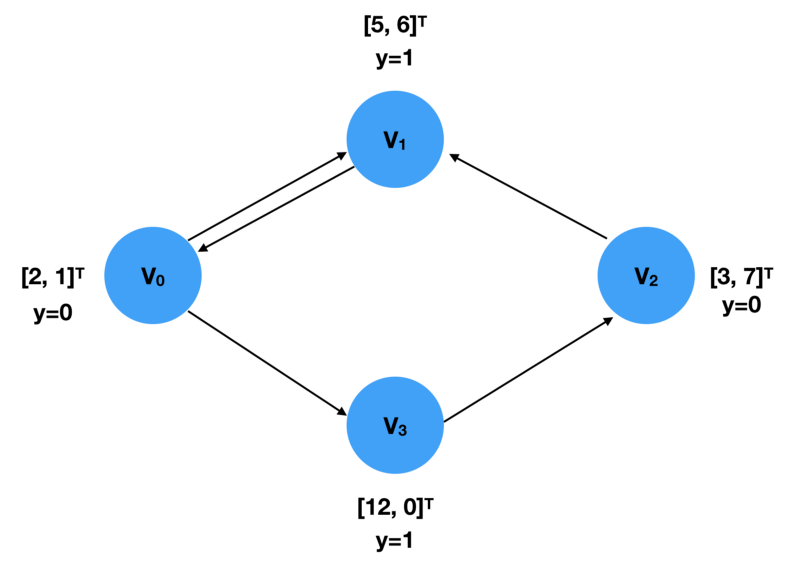

上图包含了图的几个要素：
- node对应的feature
- node对应的label
- edge的方向, 其中the first list contains the index of the source nodes, and the second list contains the index of the target nodes.


In [2]:
x = torch.tensor([[2,1], [5,6], [3,7], [12,0]], dtype=torch.float)
y = torch.tensor([0, 1, 0, 1], dtype=torch.float)

edge_index_1 = torch.tensor([[0, 1, 2, 0, 3],
              [1, 0, 1, 3, 2]], dtype=torch.long)

edge_index_2 = torch.tensor([[0, 2, 1, 0, 3],
              [3, 1, 0, 1, 2]], dtype=torch.long)

#注意到edge_index_1与edge_index_2是等价的，因为邻接矩阵的任意行\列进行交换所表达的信息是一样的

### Practice——YooChooseClick
- Predict whether there will be a buy event followed by a sequence of clicks

- Import the Data

In [3]:
import numpy as np
import pandas as pd
import os
import sys
import gc
from tqdm import tqdm

os.chdir('/content/drive/MyDrive/PhD Research/GNN')


#用户点击记录
df_click = pd.read_csv('yoochoose-clicks.dat', header=None)
df_click.columns = ['session_id', 'timestamp', 'item_id', 'category']

#用户购买记录
df_buy = pd.read_csv('yoochoose-buys.dat', header=None)
df_buy.columns = ['session_id', 'timestamp', 'item_id', 'price', 'quantity']
df_buy.head(20)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,session_id,timestamp,item_id,price,quantity
0,420374,2014-04-06T18:44:58.314Z,214537888,12462,1
1,420374,2014-04-06T18:44:58.325Z,214537850,10471,1
2,281626,2014-04-06T09:40:13.032Z,214535653,1883,1
3,420368,2014-04-04T06:13:28.848Z,214530572,6073,1
4,420368,2014-04-04T06:13:28.858Z,214835025,2617,1
5,140806,2014-04-07T09:22:28.132Z,214668193,523,1
6,140806,2014-04-07T09:22:28.176Z,214587399,1046,1
7,140806,2014-04-07T09:22:28.219Z,214586690,837,1
8,140806,2014-04-07T09:22:28.268Z,214774667,1151,1
9,140806,2014-04-07T09:22:28.280Z,214578823,1046,1


In [4]:
#选择出click记录大于2的有效样本
df_click['valid_session'] = df_click.session_id.map(df_click.groupby('session_id')['item_id'].size() > 2)
#将索引列去除
df_click = df_click.loc[df_click.valid_session].drop('valid_session', axis=1)

In [5]:
#数据量太大,随机选一部分
np.random.seed(42)
sampled_session_id = np.random.choice(df_click.session_id.unique(), 100000, replace=False)
df_click = df_click.loc[df_click.session_id.isin(sampled_session_id)]
print(df_click.nunique())

del sampled_session_id
gc.collect()

session_id    100000
timestamp     555860
item_id        22875
category         136
dtype: int64


109

In [6]:
print(df_click.shape)
print(df_click.nunique())
print('\n')

print(df_buy.shape)
print(df_buy.nunique())

(555890, 4)
session_id    100000
timestamp     555860
item_id        22875
category         136
dtype: int64


(1150753, 5)
session_id     509696
timestamp     1136477
item_id         19949
price             735
quantity           28
dtype: int64


In [7]:
#观察有无缺失值
print(df_click.isna().sum())
print('\n')
print(df_buy.isna().sum())

session_id    0
timestamp     0
item_id       0
category      0
dtype: int64


session_id    0
timestamp     0
item_id       0
price         0
quantity      0
dtype: int64


In [8]:
#average length of session
df_click.groupby('session_id')['item_id'].size().mean()

5.5589

In [9]:
from sklearn.preprocessing import LabelEncoder

df_click['item_id'] = LabelEncoder().fit_transform(df_click['item_id'])
df_click.head()

,session_id,timestamp,item_id,category
341,108,2014-04-03T11:29:34.491Z,5446,0
342,108,2014-04-03T11:30:31.064Z,5447,0
343,108,2014-04-03T11:31:36.145Z,5447,0
616,194,2014-04-04T14:29:16.071Z,15871,0
617,194,2014-04-04T14:29:47.845Z,15871,0


In [10]:
#设置有无购买的label
df_click['label'] = df_click.session_id.isin(df_buy['session_id'])
df_click.head()

print(f"正样本比例:{df_click.drop_duplicates('session_id')['label'].mean()}")

正样本比例:0.08561


某个group长这样↓

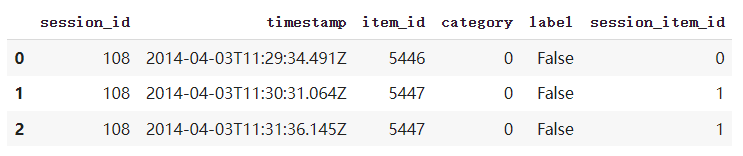

In [11]:
# PyG provides two different types of dataset classes, InMemoryDataset and Dataset.
# The former one is for data that fit in your RAM, while the second one is for much larger data

from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
class YooChooseBinaryDataset(InMemoryDataset):
  def __init__(self, root, transform=None, pre_transform=None):
    super(YooChooseBinaryDataset, self).__init__(root, transform, pre_transform)
    self.data, self.slices = torch.load(self.processed_paths[0])

  @property
  def raw_file_names(self):
    return []

  @property
  def processed_file_names(self):
    return ['yoochoose_click_binary_1M_sess.dataset']

  def download(self):
    pass

  def process(self):
    data_list = []

    #process by session_id
    groups = df_click.groupby('session_id')
    for session_id, group in tqdm(groups):
      session_item_id = LabelEncoder().fit_transform(group.item_id)
      group.reset_index(drop=True, inplace=True)
      group['session_item_id'] = session_item_id

      #node features & edge index
      #group.session_id==session_id, 这两者不本来就是完全相同的吗?
      node_feature = group.loc[group.session_id==session_id, ['session_item_id', 'item_id']].sort_values('session_item_id').item_id.drop_duplicates().values
      node_feature = torch.LongTensor(node_feature).unsqueeze(1)

      target_nodes = group.session_item_id.values[1:]
      source_nodes = group.session_item_id.values[:-1]

      #edge index的方向是根据时间戳的顺序构成, 注意target_nodes和source_nodes的顺序
      #例如用户点击商品的索引顺序是[0,1,1]，那么edge为0->1, 1->1
      #node_feature的行数==session_item_id去重后的个数
      edge_index = torch.tensor([source_nodes, target_nodes], dtype=torch.long)

      #x & y
      x = node_feature
      y = torch.FloatTensor([group.label.values[0]]) #对于某个session而言label是一样的(该用户有没有买东西),取第一个就可以

      data = Data(x=x, edge_index=edge_index, y=y)
      data_list.append(data)

    data, slices = self.collate(data_list)
    torch.save((data, slices), self.processed_paths[0])

In [12]:
dataset = YooChooseBinaryDataset(root='/content/drive/MyDrive/PhD Research/GNN')

In [13]:
#shuffle the dataset and split
dataset = dataset.shuffle()
data_train = dataset[:80000]
data_val = dataset[80000:90000]
data_test = dataset[90000:]

print(len(data_train), len(data_val), len(data_test))

80000 10000 10000


In [14]:
#create the dataloader
from torch_geometric.data import DataLoader
batch_size = 1024
train_loader = DataLoader(data_train, batch_size=batch_size)
val_loader = DataLoader(data_val, batch_size=batch_size)
test_loader = DataLoader(data_test, batch_size=batch_size)

/usr/local/lib/python3.7/dist-packages/torch_geometric/deprecation.py:12: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


- SAGEConv

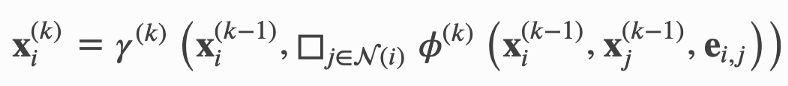

- 𝜙 denotes the message function, □ denotes the aggregation function, 𝛾 denotes the update function.
- aggregation function典型的有sum, mean, max以及attention weight加权等方法
- "If the edges in the graph have no feature other then connectivity, e is essentially the edge index of the graph".即如果没有edge feature提供，那么上述公式利用的是edge index的信息
- 上述公式即考虑当前节点的embedding，当前节点邻居的embedding以及边的信息——经过message function的变换以及aggragation function的操作——最后再一次利用当前节点的embedding，并通过update function进行更新

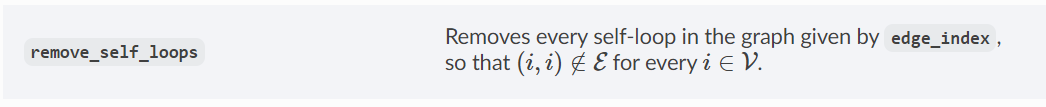

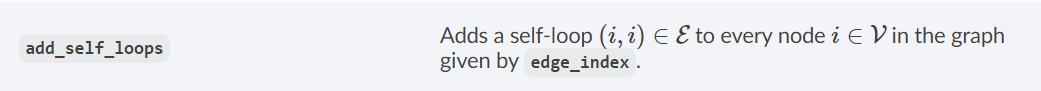

In [15]:
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops

class SAGEConv(MessagePassing):
  def __init__(self, in_channels, out_channels):
    super(SAGEConv, self).__init__(aggr='max') #default is the max aggregation

    self.lin = torch.nn.Linear(in_channels, out_channels) #linear layer
    self.act = torch.nn.ReLU() #activation layer

    self.update_lin = torch.nn.Linear(in_channels + out_channels, in_channels, bias=False) #why bias is closed?
    self.update_act = torch.nn.ReLU()

  def forward(self, x, edge_index):
    # x has shape [N, in_channels], 分别是样本数与input_size?
    # edge_index has shape [2, E], E为图中edge的个数?

    # remove_self_loops以及add_self_loops的描述见上图,作用?
    edge_index, _ = remove_self_loops(edge_index)
    edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

    # propagate function will consequently call message and update
    # 更多关于propagate的描述见https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html
    return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x)


  def message(self, x_j):
    # x_j has shape [E, in_channels]
    x_j = self.lin(x_j)
    x_j = self.act(x_j)

    return x_j

  def update(self, aggr_out, x):
    # aggr_out has shape [N, out_channels]

    new_embedding = torch.cat([aggr_out, x], dim=1)
    new_embedding = self.update_lin(new_embedding)
    new_embedding = self.update_act(new_embedding)

    return new_embedding

- Network Configuration

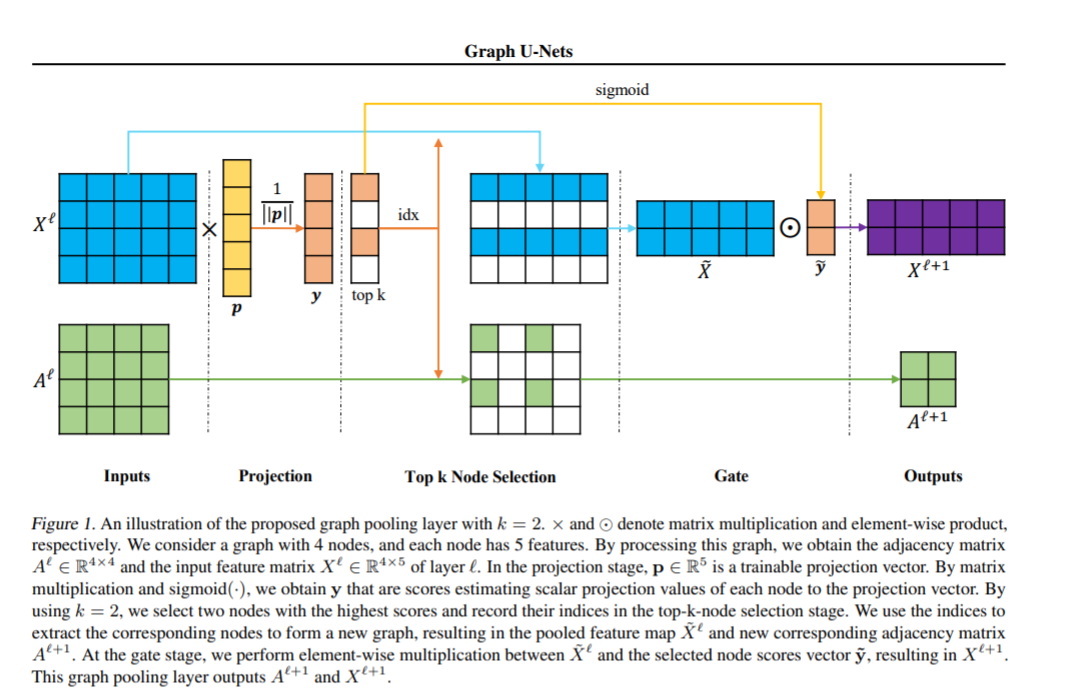

TopKPooling的作用见上图，摘自paper"Graph U-Nets"(ICML 2019), https://arxiv.org/pdf/1905.05178.pdf
- X为input feature matrix, 维度为node个数 x feature维数
- A为adjacency matrix, 维度为node个数 x node个数
- p的维数与feature维数相同, 与X矩阵相乘后(做投影)变换为y，将top k大的y对应的X_sub和A_sub选出来，实现graph层面上的pooling
- 关于TopKPooing的更加详细描述见[官方文档](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.pool.TopKPooling)
- 关于global_mean_pool, global_max_pool的详细介绍见[官方文档](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html)

In [16]:
from torch_geometric.nn import TopKPooling
from torch_geometric.nn import global_mean_pool, global_max_pool
import torch.nn.functional as F

#定义网络,集成nn.Module类
class GNN(torch.nn.Module):
  def __init__(self, embed_dim=128):
    super(GNN, self).__init__()

    # convolution layer and graph pooling layer
    self.conv_1 = SAGEConv(embed_dim, 128)
    self.pool_1 = TopKPooling(128, ratio=0.8)

    self.conv_2 = SAGEConv(128, 128)
    self.pool_2 = TopKPooling(128, ratio=0.8)

    self.conv_3 = SAGEConv(128, 128)
    self.pool_3 = TopKPooling(128, ratio=0.8)

    # A simple lookup table that stores embeddings of a fixed dictionary and size.
    #see https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html
    self.item_embedding = torch.nn.Embedding(num_embeddings=df_click.item_id.max()+1, embedding_dim=embed_dim)

    # linear layer
    self.lin_1 = torch.nn.Linear(256, 128)
    self.lin_2 = torch.nn.Linear(128, 64)
    self.lin_3 = torch.nn.Linear(64, 1)

    # batchnorm layer
    self.bn_1 = torch.nn.BatchNorm1d(128)
    self.bn_2 = torch.nn.BatchNorm1d(64)

    # activation layer
    self.act_1 = torch.nn.ReLU()
    self.act_2 = torch.nn.ReLU()

  def forward(self, data):
    x, edge_index, batch = data.x, data.edge_index, data.batch
    x = self.item_embedding(x)
    x = x.squeeze(1)

    x = F.relu(self.conv_1(x, edge_index))
    #注意TopKPooling function现在返回的值有六个,为return x, edge_index, edge_attr, batch, perm, score[perm]
    #故下一行代码修改了一下(参照了https://github.com/khuangaf/PyTorch-Geometric-YooChoose/issues/9)
    x, edge_index, _, batch, _, _ = self.pool_1(x, edge_index, None, batch)
    x_1 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

    x = F.relu(self.conv_2(x, edge_index))
    x, edge_index, _, batch, _, _ = self.pool_2(x, edge_index, None, batch)
    x_2 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

    x = F.relu(self.conv_3(x, edge_index))
    x, edge_index, _, batch, _, _ = self.pool_3(x, edge_index, None, batch)
    x_3 = torch.cat([global_max_pool(x, batch), global_mean_pool(x, batch)], dim=1)

    x = x_1 + x_2 + x_3

    x = self.lin_1(x)
    x = self.act_1(x)
    x = self.lin_2(x)
    x = self.act_2(x)

    x = F.dropout(x, p=0.5, training=self.training)
    x = torch.sigmoid(self.lin_3(x)).squeeze(1) #to probability

    return x

- fitting

In [17]:
#set device
def get_device():
  if torch.cuda.is_available():
      n_gpu = torch.cuda.device_count()
      print(f'number of gpu: {n_gpu}')
      print(f'cuda name: {torch.cuda.get_device_name(0)}')
      print('GPU is on')
  else:
      print('GPU is off')

  device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
  return device

device = get_device()

model = GNN().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
criterion = torch.nn.BCELoss()

number of gpu: 1
cuda name: Tesla K80
GPU is on


In [18]:
#training function
def train():
  model.train()
  loss_all = 0

  for data in train_loader:
    data = data.to(device)
    label = data.y.to(device)

    #clear gradient
    optimizer.zero_grad()
    #forward pass
    output = model(data)
    #backward pass
    loss = criterion(output, label)
    loss.backward()
    loss_all += data.num_graphs * loss.item() #?
    #update
    optimizer.step()

  return loss_all / len(data_train)


#validation function
from sklearn.metrics import roc_auc_score
def evaluate(loader):
  model.eval()

  y_preds = []
  y_trues = []

  with torch.no_grad():
    for data in loader:
      data = data.to(device)
      y_pred = model(data).detach().cpu().numpy()
      y_true = data.y.detach().cpu().numpy()

      y_preds.append(y_pred)
      y_trues.append(y_true)

  y_preds = np.hstack(y_preds)
  y_trues = np.hstack(y_trues)

  return roc_auc_score(y_trues, y_preds)

In [19]:
import time

In [ ]:
epochs = 20
for epoch in range(epochs):

  start_time = time.time()
  loss_epoch = train()
  end_time = time.time()

  acc_train, acc_val, acc_test = evaluate(train_loader), evaluate(val_loader), evaluate(test_loader)
  print(f'Epoch: {epoch}, train acc: {acc_train}, val acc: {acc_val}, test acc: {acc_test}, training time:{end_time-start_time}')

Epoch: 0, train acc: 0.7272969589827917, val acc: 0.64203458011411, test acc: 0.6289356060138876, training time:32.0009400844574
Epoch: 1, train acc: 0.8115361853080896, val acc: 0.677546541213806, test acc: 0.6579046362189963, training time:24.217416763305664
Epoch: 2, train acc: 0.8445801757253872, val acc: 0.6755679314224086, test acc: 0.6580564634492285, training time:24.627615690231323
Epoch: 3, train acc: 0.8544939691307496, val acc: 0.6652889785571061, test acc: 0.651906473932831, training time:24.143285751342773
Epoch: 4, train acc: 0.8538257297658175, val acc: 0.648102308543377, test acc: 0.6407943487216172, training time:24.54833722114563
Epoch: 5, train acc: 0.8560170890898574, val acc: 0.646008163113512, test acc: 0.6361447477151914, training time:24.3211932182312
Epoch: 6, train acc: 0.8518883183680194, val acc: 0.6353020878851834, test acc: 0.6286709875553472, training time:24.488451957702637
Epoch: 7, train acc: 0.8549096312590528, val acc: 0.6390299097222867, test acc: 